In [1]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)
xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cmems_climato_2002_2014.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_HOT_climato_obs_npp_opti_all_parameters_1_group_night"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (latitude: 1, longitude: 1, depth: 3, time: 1821)
Coordinates: (4)
Data variables: (13)

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.10354321928514 114.18750083099961 113.81216693411004 ... 113.72807877620157 113.59442872389666 112.94051799923405]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 44kB
Dimensions:          (time: 1821, latitude: 1, longitude: 1)
Coordinates: (3)
Data variables: (2)
Attributes: (2)

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[157.47344759476223]]] [[[174.99215551657466]]] [[[208.68867932515434]]] [[[246.76450400344189]]] [[[267.6429883219692]]] [[[287.28666481880026]]] [[[296.5449412143214]]] [[[316.72791533460037]]] [[[306.5964837984304]]] [[[251.89578358636166]]] [[[202.07960087566033]]] [[[173.46762959837844]]] [[[157.47344759476223]]] [[[174.99215551657466]]] [[[208.68867932515434]]] [[[246.76450400344189]]] [[[267.6429883219692]]] [[[287.28666481880026]]] [[[296.5449412143214]]] [[[316.72791533460037]]] [[[306.5964837984304]]] [[[251.89578358636166]]] [[[202.07960087566033]]] [[[173.46762959837844]]] [[[157.47344759476223]]] [[[174.99215551657466]]] [[[208.68867932515434]]] [[[246.76450400344189]]] [[[267.6429883219692]]] [[[287.28666481880026]]] [[[296.5449412143214]]] [[[316.72791533460037]]] [[[306.5964837984304]]] [[[251.89578358636166]]] [[[202.07960087566033]]] [[[173.46762959837844]]] [[[157.47344759476223]]] [[[174.99215551657466]]] [[[205.11964203889096]]] [[[249.41101354758015]]] [[[274.9843536846903]]] [[[286.8903991689449]]] [[[295.1220610418843]]] [[[309.9996216403426]]] [[[304.69609270417214]]] [[[258.80818309953133]]] [[[199.0891024480229]]] [[[172.93929209645245]]] [[[157.47344759476223]]] [[[174.99215551657466]]] [[[208.68867932515434]]] [[[246.76450400344189]]] [[[267.6429883219692]]] [[[287.28666481880026]]] [[[296.5449412143214]]] [[[316.72791533460037]]] [[[306.5964837984304]]] [[[251.89578358636166]]] [[[202.07960087566033]]] [[[173.46762959837844]]]]
Units,milligram/meter2
Magnitude,[[[[165.14088942657816]]] [[[178.92376529527033]]] [[[210.587880910585]]] [[[239.76110603203807]]] [[[267.2464541828776]]] [[[288.8287185974808]]] [[[297.96737505027676]]] [[[311.0964445911835]]] [[[293.93665064131324]]] [[[250.6762698623868]]] [[[206.8791595465224]]] [[[175.162623726281]]] [[[165.14088942657816]]] [[[178.92376529527033]]] [[[210.587880910585]]] [[[239.76110603203807]]] [[[267.2464541828776]]] [[[288.8287185974808]]] [[[297.96737505027676]]] [[[311.0964445911835]]] [[[293.93665064131324]]] [[[250.6762698623868]]] [[[206.8791595465224]]] [[[175.162623726281]]] [[[165.14088942657816]]] [[[178.92376529527033]]] [[[210.587880910585]]] [[[239.76110603203807]]] [[[267.2464541828776]]] [[[288.8287185974808]]] [[[297.96737505027676]]] [[[311.0964445911835]]] [[[293.93665064131324]]] [[[250.6762698623868]]] [[[206.8791595465224]]] [[[175.162623726281]]] [[[165.14088942657816]]] [[[178.92376529527033]]] [[[206.98636308299828]]] [[[242.33250526139435]]] [[[274.57694273536686]]] [[[288.4303259329828]]] [[[296.53766976427175]]] [[[304.4877809871636]]] [[[292.11472957348354]]] [[[257.5552040830776]]] [[[203.81763429284032]]] [[[174.62912371094896]]] [[[165.14088942657816]]] [[[178.92376529527033]]] [[[210.587880910585]]] [[[239.76110603203807]]] [[[267.2464541828776]]] [[[288.8287185974808]]] [[[297.96737505027676]]] [[[311.0964445911835]]] [[[293.93665064131324]]] [[[250.6762698623868]]] [[[206.8791595465224]]] [[[175.162623726281]]]]
Units,milligram/meter2
Magnitude,[[[[252.09962791447603]]] [[[303.2139854737723]]] [[[340.65921743635005]]] [[[400.491074282383]]] [[[402.5676942405602]]] [[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[340.65921743635005]]] [[[400.491074282383]]] [[[402.5676942405602]]] [[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[340.65921743635005]]] [[[400.491074282383]]] [[[402.5676942405602]]] [[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[334.8331925035588]]] [[[404.78627652271706]]] [[[413.

observations


Select the kind of observation you want to use.


In [8]:
# observations_selected = observations[["day_lowess_0.2", "night_lowess_0.2"]].rename(
#     {"day_lowess_0.2": "day", "night_lowess_0.2": "night"}
# )

observations_selected = observations[["night"]]

Remove the X first months to let the model reach the stationary state.


In [9]:
observations_selected_without_init = observations_selected.isel(time=slice(STABILIZATION_TIME, None))
observations_selected_without_init

Magnitude,[[[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[340.65921743635005]]] [[[400.491074282383]]] [[[402.5676942405602]]] [[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[340.65921743635005]]] [[[400.491074282383]]] [[[402.5676942405602]]] [[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[334.8331925035588]]] [[[404.78627652271706]]] [[[413.6100030459486]]] [[[428.8615197401235]]] [[[459.1095560040171]]] [[[444.7386959455062]]] [[[421.56777193702305]]] [[[414.7512505800877]]] [[[351.1188642345709]]] [[[293.60974298007943]]] [[[252.09962791447603]]] [[[303.2139854737723]]] [[[340.65921743635005]]] [[[400.491074282383]]] [[[402.5676942405602]]] [[[429.4538821520762]]] [[[461.3230736309552]]] [[[454.391393415551]]] [[[424.19709229458095]]] [[[403.6738329024025]]] [[[356.39298722018964]]] [[[294.5067342668294]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [10]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=observed_npp["l12"], resolution=1 / 12, timestep=1),
)

2025-04-11 10:30:50,744 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [11]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 100, 200),
    ),
]

In [12]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[
        Observation(name="Hot climato", observation=observations_selected_without_init, observation_type="monthly")
    ],
    normalized_mse=True,
    root_mse=True,
)

Set the genetic algorithm meta parameters.


In [13]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.30,
    INDPB=0.2,
    ETA=5,
    CXPB=0.7,
    NGEN=5,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Finaly, create the Genetic Algorithm.


In [14]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    client=client,
    logbook_path=f"{export_file_name}_logbook.json",
)

And watch the magic on the Dask dashboard :


In [15]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51513,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:51527,Total threads: 3
Dashboard: http://127.0.0.1:51531/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:51516,


## Run the optimization


In [16]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,-21.901226,45.631353,-359.953785,-0.547653,500,0.000
1,-4.929273,9.946379,-118.080388,-0.451523,500,0.194
2,-3.583992,6.978691,-86.034062,-0.326368,500,0.186
3,-3.113665,8.034595,-124.490588,-0.267521,500,0.222
4,-2.969873,7.429593,-97.974902,-0.267521,500,0.206


Generations: 100%|██████████| 5/5 [01:41<00:00, 20.36s/it]


## Optimization statistics


In [17]:
viewer.hall_of_fame.head(10)

,,D1N1_energy_coefficient,D1N1_tr_max,D1N1_tr_rate,D1N1_inv_lambda_max,D1N1_inv_lambda_rate,fitness
generation,individual,,,,,,
3,331,0.054416,40.171096,-0.025097,138.124290,-0.082755,0.267521
2,13,0.054416,46.648878,-0.025097,138.124290,-0.082755,0.326368
4,244,0.056485,21.969722,-0.183335,141.248669,-0.085002,0.406488
3,197,0.056485,21.969722,-0.183335,141.248669,-0.085002,0.406488
4,90,0.212542,35.988616,-0.008872,138.822916,-0.146044,0.419512
2,409,0.252439,38.952475,-0.013179,174.084849,-0.163181,0.441805
1,152,0.215451,35.988616,-0.018907,138.822916,-0.146044,0.451523
4,215,0.215451,35.988616,-0.018907,138.822916,-0.146044,0.451523
2,361,0.243957,44.924262,-0.025121,149.903760,-0.155070,0.471172


In [18]:
viewer.fitness_evolution()

In [19]:
viewer.parameters_standardized_deviation()

In [20]:
viewer.parameters_scatter_matrix(nbest=2000)

In [26]:
fig = viewer.box_plot(3, nbest=500)
fig.show()

In [27]:
groups = [["D1N1_energy_coefficient", "D1N1_tr_rate", "D1N1_tr_max", "D1N1_inv_lambda_rate", "D1N1_inv_lambda_max"]]

fig = viewer.parallel_coordinates(nbest=100, unselected_opacity=0, parameter_groups=groups, uniformed=True)

for group in fig:
    display(group)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning:

n_quantiles (1000) is greater than the total number of samples (100). n_quantiles is set to n_samples.



In [23]:
if SAVE:
    for i, trace in enumerate(fig):
        trace.write_html(f"Parallel_coordinates_{export_file_name}_{i}.html")

# Plots


### Time series of X best individuals


In [24]:
import plotly.graph_objects as go

interval = 50
old_figure = viewer.time_series(interval, title=["HOT"], client=client)[0]


figure_update = go.Figure()

figure_update.add_trace(old_figure.data[0].update(name="Optimal parameterization", xaxis="x", yaxis="y"))
figure_update.add_trace(old_figure.data[1].update(xaxis="x", yaxis="y", showlegend=False))
figure_update.add_trace(old_figure.data[2].update(name="Observations", xaxis="x", yaxis="y"))


original = (
    viewer.original_simulation.pint.quantify()
    .pint.to("mg/m2")
    .mean(["functional_group", "latitude", "longitude"])
    .to_series()
    .reset_index()
)
figure_update.add_trace(
    go.Scatter(
        x=original["time"],
        y=original["biomass"],
        mode="lines",
        name="Original parameterization",
        line=dict(color="red", width=2),
    )
)

figure_update.update_layout(
    title="Comparison of parameterization at the HOT station",
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    legend_title="",
)
figure_update.update_layout(width=1400 / 2, height=600 / 1.5)

In [25]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

AttributeError: 'list' object has no attribute 'write_html'

### Taylor Diagram


In [ ]:
fig = viewer.taylor_diagram(1, client=client)
# dont show legend
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
monthly_obs = (
    observations["night"]
    .pint.quantify()
    .pint.to("mg/m2")
    .mean(["latitude", "longitude", "layer"])
    .sel(time=slice("2006", "2007"))
)
monthly_obs

<xarray.DataArray 'night' (time: 24)> Size: 192B
252.1 303.2 340.7 400.5 402.6 429.5 ... 461.3 454.4 424.2 403.7 356.4 294.5
Coordinates: (1)

In [ ]:
monthly_pred_opti = (
    viewer.best_individuals_simulations(1)
    .pint.quantify()
    .pint.to("mg/m2")
    .mean(["latitude", "longitude", "individual", "functional_group"])
    .sel(time=slice("2006", "2007"))
).interp_like(monthly_obs)
monthly_pred_opti

<xarray.DataArray <ForcingLabels.biomass: 'biomass'> (time: 24)> Size: 192B
291.5 301.0 330.6 371.8 416.1 447.4 ... 459.5 448.3 430.5 394.9 356.0 312.8
Coordinates: (1)

In [ ]:
monthly_pred_original = (
    viewer.original_simulation.pint.quantify()
    .pint.to("mg/m2")
    .mean(["latitude", "longitude", "functional_group"])
    .sel(time=slice("2006", "2007"))
    .interp_like(monthly_obs)
)
monthly_pred_original

<xarray.DataArray <ForcingLabels.biomass: 'biomass'> (time: 24)> Size: 192B
211.3 250.7 289.0 337.3 356.2 365.6 ... 339.3 311.7 282.3 245.1 220.0 195.7
Coordinates: (1)

correlation [0.9672819144089544, 0.7535665016979493]
norm STD [0.9115805883588138, 0.8770531325165515]
bias [0.044517284846474395, -1.4561186496838512]
NRMSE [0.25974667616947905, 0.6688695504428682]
name ['Prediction', 'Original parameterization']


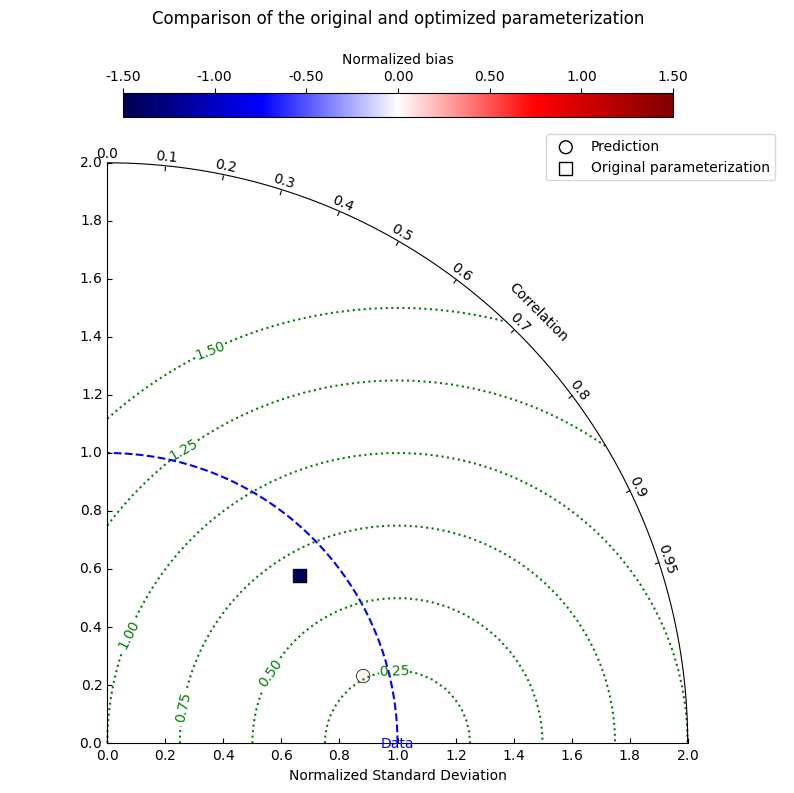

In [ ]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_opti, monthly_pred_original]
all_obs = [monthly_obs, monthly_obs]

all_names = ["Prediction", "Original parameterization"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs.to_series(), model=model.to_series(), name=name)
diagram.plot()
plt.title("Comparison of the original and optimized parameterization\n")

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()